In [1]:
import simfin as sf
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import altair as alt

You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


Import data

In [2]:
# Set your API-key for downloading data. This key gets the free data.
sf.set_api_key('free')

# Set the local directory where data-files are stored.
# The directory will be created if it does not already exist.
sf.set_data_dir('~/simfin_data/')

# Download the data from the SimFin server and load into a Pandas DataFrame.
df = sf.load_shareprices(variant='daily', market='us')

Dataset "us-shareprices-daily" on disk (0 days old).
- Loading from disk ... Done!


Get the last entry for each Ticker per month and reset index.

In [3]:
df= df.groupby(by=[pd.Grouper(level='Ticker'), pd.Grouper(level='Date', freq='M')]).last()
df = df.reset_index()

In [4]:
column_dtypes = {
    'Ticker'       :          'str',
'Date'             :      'str' ,
'SimFinId'         :       'uint32',
'Open'             :     'float64',
'Low'              :     'float64',
'High'             :     'float64',
'Close'            :     'float64',
'Adj. Close'       :     'float64',
'Dividend'         :     'float64',
'Volume'           :     'float64',
'Shares Outstanding':    'float64'}
#parse_dates = ['Date']
#df= pd.read_csv("SimFin_mth.csv", dtype = column_dtypes, parse_dates=parse_dates) 
df['Date'] = pd.to_datetime(df['Date'].astype('str'))
df['Year'] = df['Date'].dt.strftime('%Y')
df['Month'] = df['Date'].dt.strftime('%m')
df = df.set_index(['Ticker','Year','Month'])
last = df.groupby(level = 'Ticker').last()[['Date','Adj. Close']]
df = df.join(last, rsuffix='_last')
df = df[df['Close'] < 99999999]  #exclude bad data

Offset year and join to last known entry

In [5]:
#temp reduction in scope
#df = df['UFS':'UG'][['Adj. Close','Adj. Close_last']]
df['1Y'] = round(1/(1+df.groupby(level='Ticker')['Adj. Close'].apply(lambda x: x.pct_change(periods = -12))),5)
df['2Y'] = round(1/(1+df.groupby(level='Ticker')['Adj. Close'].apply(lambda x: x.pct_change(periods = -24))),5)
df['3Y'] = round(1/(1+df.groupby(level='Ticker')['Adj. Close'].apply(lambda x: x.pct_change(periods = -36))),5)
df['5Y'] = round(1/(1+df.groupby(level='Ticker')['Adj. Close'].apply(lambda x: x.pct_change(periods = -60))),5)
df.replace([np.inf, -np.inf], np.nan)
df['1Y']= round(df['1Y'].fillna(df['Adj. Close_last']/df['Adj. Close']-1),5)
df['2Y']= round(df['2Y'].fillna(df['Adj. Close_last']/df['Adj. Close']-1),5)
df['3Y']= round(df['3Y'].fillna(df['Adj. Close_last']/df['Adj. Close']-1),5)
df['5Y']= round(df['5Y'].fillna(df['Adj. Close_last']/df['Adj. Close']-1),5)
df['MktCap'] = round(df['Shares Outstanding'] * df['Close'],0)
df['VolAmt'] = round(df.groupby(['Ticker','Year']).agg(sum)['Volume'] * df['Close'],0)

Export to CSV

In [6]:
#df.to_csv('SimFin_mth_out.csv')

Weird selections - data quality considerations

In [7]:
#df['1Y'].max()
#df[df['Dividend'].isnull()]['1Y'].mean() # much higher than with div
#for n in range(1,100,5):
#  print(n, df[df['Adj. Close']>n]['1Y'].mean() - df['1Y'].mean()) # 11% less return for stocks with adj. close higher than 10??
#[df[df['Shares Outstanding'].isnull()]['1Y'].count(), df[df['Shares Outstanding'].isnull()]['1Y'].mean() - df['1Y'].mean()] # missing shares outstanding = outperformance 

Analysis of delta between full sample of 600 largest companies each month and n-sample for 1-5 year returns. Note that time horizon of x is not meaningful for startpoint higher than x years from 2019

In [8]:
df1y = df.loc(axis=0)[:,'2007':'2018',:]
out_list = []
for y in ['2009', '2010','2011', '2012', '2013','2014', '2015', '2016', '2017', '2018']:
    for m in ['01','02','03','04','04','05','06','07','08','09','10','11','12']:
        df_run = df1y.loc(axis=0)[:,y,m].nlargest(500,'VolAmt')
        period_mean = df_run[['1Y', '2Y', '3Y', '5Y']].mean()
        out_list.append([y, m, 'mean', 0, 
        period_mean['1Y'], 
        period_mean['2Y']**(1/2),
        period_mean['3Y']**(1/3),
        period_mean['5Y']**(1/5)]) 

        period_median = df_run[['1Y', '2Y', '3Y', '5Y']].median()
        out_list.append([y, m, 'median', 0, 
        period_median['1Y']-period_mean['1Y'], 
        period_median['2Y']**(1/2),
        period_median['3Y']**(1/3),
        period_median['5Y']**(1/5)]) 
        for n in [30, 50, 100,150]:
            for s in range (1,100):
                sample_mean = df_run.sample(n, random_state = s)[['1Y', '2Y', '3Y', '5Y']].mean()
                out_list.append([y, m, n, s, 
                sample_mean['1Y']-period_mean['1Y'], 
                sample_mean['2Y']**(1/2)-period_mean['2Y']**(1/2),
                sample_mean['3Y']**(1/3)-period_mean['3Y']**(1/3),
                sample_mean['5Y']**(1/5)-period_mean['5Y']**(1/5)]) 
                

#consider also weights df1.sample(n = 3, weights = test_weights) 

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


In [9]:
out = pd.DataFrame(out_list)
out.columns = ['m', 'y', 'n','s', 'delta1y', 'delta2y', 'delta3y', 'delta5y']
out = out.astype(dtype={'m': 'category',
                   'y': 'int64',
                   'n': 'str',
                   's': 'int64',
                   'delta1y': 'float16',
                   'delta2y': 'float16',
                   'delta3y': 'float16',
                   'delta5y': 'float16'})
out

,m,y,n,s,delta1y,delta2y,delta3y,delta5y
0,2009,1,mean,0,1.509766,1.395508,1.251953,1.234375
1,2009,1,median,0,-0.130249,1.323242,1.199219,1.199219
2,2009,1,30,1,-0.129272,-0.027023,-0.006859,0.009903
3,2009,1,30,2,0.123230,0.056976,0.027786,-0.010101
4,2009,1,30,3,-0.030884,-0.007702,-0.001237,-0.002979
...,...,...,...,...,...,...,...,...
51735,2018,12,150,95,0.004036,-0.002529,-0.002096,-0.001497
51736,2018,12,150,96,0.014160,0.007133,0.005894,0.004200
51737,2018,12,150,97,-0.039246,-0.018784,-0.015640,-0.011223
51738,2018,12,150,98,-0.007721,-0.020584,-0.017166,-0.012321


Exclude incomplete series (e.g. 5 year analysis with start later than 2014)

In [29]:
out.loc[(out.y > 2014) , 'delta5y'] = np.nan 
out.loc[(out.y > 2016) , 'delta3y'] = np.nan 
out.loc[(out.y > 2017) , 'delta2y'] = np.nan 
out['n'] = out.n.str.zfill(3)

Visualize: Boxplot of CAGR return of sample minus full universe: 
- Median (Solid)
- Mean (Dashed)
- Bottom to top quintile (Box)
- 10-90 percentile (Whiskers)

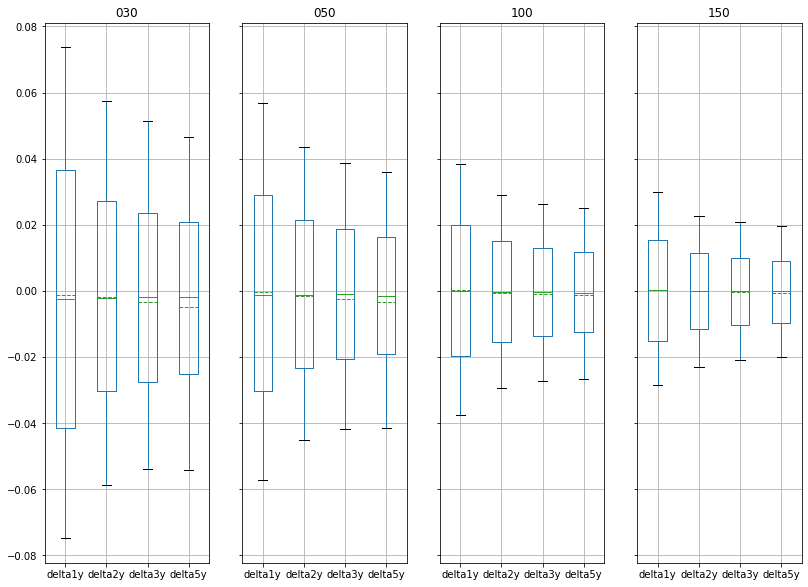

In [28]:
out_plot = out[~out.n.isin(['mean', 'median'])]
fig = out_plot[['n','delta1y', 'delta2y', 'delta3y', 'delta5y']].groupby('n').boxplot(figsize = [20,10], sym = '', whis = [10, 90], meanline = True, showmeans = True, layout = (1,6))

In [54]:
for show in ['030', '050', '100','150']:
    print(show, out[out.n.isin([show])][['delta1y', 'delta2y', 'delta3y', 'delta5y']].describe())

030             delta1y       delta2y       delta3y       delta5y
count  12870.000000  12805.000000  12797.000000  12790.000000
mean      -0.001298     -0.001743     -0.003294     -0.005005
std        0.060974      0.049194      0.051147      0.049225
min       -0.329590     -0.413818     -0.465088     -0.427246
25%       -0.041336     -0.030304     -0.027435     -0.025269
50%       -0.002502     -0.002165     -0.001727     -0.001984
75%        0.036682      0.027206      0.023560      0.020798
max        0.592773      0.209229      0.219604      0.209473
050             delta1y       delta2y       delta3y       delta5y
count  12870.000000  12847.000000  12846.000000  12846.000000
mean      -0.000287     -0.001436     -0.002415     -0.003498
std        0.046143      0.038422      0.039368      0.038055
min       -0.214355     -0.275635     -0.377441     -0.484375
25%       -0.030331     -0.023453     -0.020538     -0.018982
50%       -0.001100     -0.001321     -0.001093     -0.001487
